### In this notebook I will test and show the final resaults from the 2 ML models 
### I added some extra features here that I thought can improve the models -  and they did!
**In addition here I chose to other feature selection method**

In [1]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict

In [2]:
def regressionMetrics(y, yhat):
    res = {
        'MSE': metrics.mean_squared_error(y, yhat),
        'RMSE': np.sqrt(metrics.mean_squared_error(y, yhat)),
        'MAE': metrics.mean_absolute_error(y, yhat),
        'R2': metrics.r2_score(y, yhat)
    }

    # Check if all values are > -1 to safely apply log
    if np.all(y > -1) and np.all(yhat > -1):
        rmsle = np.sqrt(metrics.mean_squared_log_error(y, yhat))
        res['RMSLE'] = rmsle
    else:
        res['RMSLE'] = 'Not applicable (values ≤ -1)'

    return res

# load the df for test

In [15]:
df = pd.read_pickle('df_with_ev_ind.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 11 to 2083
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2073 non-null   datetime64[ns]
 1   SPY_return                     2073 non-null   float64       
 2   SPY_Volume                     2073 non-null   float64       
 3   AAPL                           2073 non-null   float64       
 4   MSFT                           2073 non-null   float64       
 5   GOOG                           2073 non-null   float64       
 6   GLD                            2073 non-null   float64       
 7   SLV                            2073 non-null   float64       
 8   ^TNX                           2073 non-null   float64       
 9   DX-Y.NYB                       2073 non-null   float64       
 10  JPY=X                          2073 non-null   float64       
 11  EUR=X                

## Drop duplicates / clean the data 

In [16]:
df.reset_index(drop=True, inplace=True)
df = df.dropna()
df = df.drop_duplicates(subset='ds')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 0 to 2072
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X                 

,ds,SPY_return,SPY_Volume,AAPL,MSFT,GOOG,GLD,SLV,^TNX,DX-Y.NYB,...,March,April,May,June,July,August,September,October,November,December
0,2017-01-23,-0.269012,-10.789544,0.066658,0.350635,1.775112,0.643197,0.617668,-2.594240,-0.575734,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-24,0.656459,20.971780,-0.091620,0.889458,0.556575,-0.449093,-0.429721,2.829789,0.189691,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-25,0.802609,0.848583,1.592078,0.251904,1.432266,-0.824149,-0.739821,2.104413,-0.318884,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-26,-0.073538,-6.178462,0.049234,0.926479,-0.421220,-0.927220,-1.055901,-0.594534,0.349894,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-27,-0.086646,-13.127196,0.008170,2.349481,-1.062304,0.203069,1.820458,-1.076553,0.149434,...,0,0,0,0,0,0,0,0,0,0


# Add PE ratio
Here I am adding new external data that I thought of after some time of testing the models

In [17]:
pe = pd.read_csv('pe-ratio.csv')
pe = pe.iloc[1:]
pe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        331 non-null    object 
 1   shiler pe   331 non-null    object 
 2   PE          340 non-null    object 
 3   Unnamed: 3  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 10.8+ KB


In [18]:
df_c = df.copy()
pe['date'] = pd.to_datetime(pe['date'])
pe.info()   
pe['month'] = pe['date'].dt.month
pe['year'] = pe['date'].dt.year
df_c['month'] = df_c['ds'].dt.month
df_c['year'] = df_c['ds'].dt.year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        331 non-null    datetime64[ns]
 1   shiler pe   331 non-null    object        
 2   PE          340 non-null    object        
 3   Unnamed: 3  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.8+ KB


In [19]:
#pe['PE'].head(30)
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 0 to 2072
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X                 

In [20]:
#make the change on the copy df
df_c = pd.merge(df_c,pe[['month','year','PE','shiler pe']],how='left',on=['month','year'])
df_c.drop(['year', 'month'], axis=1, inplace=True)
df_c.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X            

In [21]:
df_c['shiler pe'].head(20)

0       28.06
1       28.06
2       28.06
3       28.06
4       28.06
5       28.06
6       28.06
7       28.66
8       28.66
9       28.66
10      28.66
11      28.66
12      28.66
13      28.66
14      28.66
15      28.66
16      28.66
17      28.66
18      28.66
19      28.66
Name: shiler pe, dtype: object

## Convert the object types:

In [22]:
df_c[['ds','PE']].tail(25)
for col in ['PE', 'shiler pe']:  # replace with your actual column names
    df_c[col] = (
        df_c[col]
        .astype(str)                    # ensure string type
        .str.replace(r'[^\d\.\-]', '', regex=True)  # remove all but digits, dot, minus
        .str.strip()                    # remove leading/trailing whitespace
    )
    df_c[col] = pd.to_numeric(df_c[col], errors='coerce')

    
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X            

## Use only the shiler pe 
Yields the best resaults

In [23]:
merged = pd.merge(df, df_c[['ds','shiler pe']], on='ds', how='left') # add only the shiler pe column


df=merged
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 97 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X            

In [24]:
# H andle economic data columns
# Run only once!!
lst =['Actual_GDP','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
for col in lst:
    df[col] = df[col] *100

df['Actual_GDP'].head(20)




0    -500.0
1    -500.0
2    -500.0
3    -500.0
4       1.9
5    -500.0
6    -500.0
7    -500.0
8    -500.0
9    -500.0
10   -500.0
11   -500.0
12   -500.0
13   -500.0
14   -500.0
15   -500.0
16   -500.0
17   -500.0
18   -500.0
19   -500.0
Name: Actual_GDP, dtype: float64

# Have the rate as feature

does not necessarily helps 

In [25]:
df_test = df.copy()

### Optional, when testing the models,I can go back to the original df withiut running all from the begining

In [76]:
df = df_test

## This df is to add feture to the model df

In [26]:
df_add = pd.read_pickle('combined_cleaned_add.pkl')
df_add.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Close            2084 non-null   float64
 1   SPY_Volume           2084 non-null   int64  
 2   AAPL                 2084 non-null   float64
 3   MSFT                 2084 non-null   float64
 4   GOOG                 2084 non-null   float64
 5   GLD                  2084 non-null   float64
 6   SLV                  2084 non-null   float64
 7   ^TNX                 2084 non-null   float64
 8   DX-Y.NYB             2084 non-null   float64
 9   JPY=X                2084 non-null   float64
 10  EUR=X                2084 non-null   float64
 11  USO                  2084 non-null   float64
 12  UNG                  2084 non-null   float64
 13  BTC-USD              2084 non-null   float64
 14  CPER                 2084 non-null   float64
 15  ^VIX                

## Add support & resistance areas

In [27]:
from scipy.signal import argrelextrema
spy_zones = df_add.copy()

# Use N = window size to define "local"
N = 10

# Find local maxima (resistance) and minima (support)
spy_zones['local_max'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.greater_equal, order=N)[0]]
spy_zones['local_min'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.less_equal, order=N)[0]]


# Define zone precision (e.g., $5 buckets)
zone_precision = 100
support_levels = spy_zones['local_min'].dropna().round(-int(np.log10(zone_precision)))
resistance_levels = spy_zones['local_max'].dropna().round(-int(np.log10(zone_precision)))

support_zones = support_levels.value_counts().loc[lambda x: x > 1].index.tolist()
resistance_zones = resistance_levels.value_counts().loc[lambda x: x > 1].index.tolist()


In [28]:
# define your margins
margin_sup = 50.0    # dollars above support to trigger 1
margin_res = 50.0    # dollars below resistance to trigger -1

def support_signal(price):
    # compute (distance, support) for only those supports below or equal to price
    diffs = [(price - s, s) for s in support_zones if s <= price]
    if not diffs:
        return 0
    # pick the smallest positive distance
    nearest_diff, nearest_sup = min(diffs, key=lambda x: x[0])
    return 1 if nearest_diff <= margin_sup else 0

def resistance_signal(price):
    # compute (distance, resistance) for only those resistances above or equal to price
    diffs = [(r - price, r) for r in resistance_zones if r >= price]
    if not diffs:
        return 0
    nearest_diff, nearest_res = min(diffs, key=lambda x: x[0])
    return -1 if nearest_diff <= margin_res else 0

# apply to your DataFrame
spy_zones['SUPPORT_Signal']    = spy_zones['SPY_Close'].apply(support_signal)
spy_zones['RESISTANCE_Signal'] = spy_zones['SPY_Close'].apply(resistance_signal)

# quick check
print(spy_zones[['SPY_Close','SUPPORT_Signal','RESISTANCE_Signal']].tail(60))


              SPY_Close  SUPPORT_Signal  RESISTANCE_Signal
Date                                                      
2025-01-22  6086.370117               0                 -1
2025-01-23  6118.709961               0                  0
2025-01-24  6101.240234               0                  0
2025-01-27  6012.279785               0                  0
2025-01-28  6067.700195               0                 -1
2025-01-29  6039.310059               0                  0
2025-01-30  6071.169922               0                 -1
2025-01-31  6040.529785               0                  0
2025-02-03  5994.569824               0                  0
2025-02-04  6037.879883               0                  0
2025-02-05  6061.479980               0                 -1
2025-02-06  6083.569824               0                 -1
2025-02-07  6025.990234               0                  0
2025-02-10  6066.439941               0                 -1
2025-02-11  6068.500000               0                 

In [29]:
spy_zones['yest_support_signal'] = spy_zones['SUPPORT_Signal'].shift(1)
spy_zones['yest_resistance_signal'] = spy_zones['RESISTANCE_Signal'].shift(1)
#spy_zones['2d_support_signal'] = spy_zones['SUPPORT_Signal'].shift(2)
#spy_zones['2d_resistance_signal'] = spy_zones['RESISTANCE_Signal'].shift(2)
spy_zones.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2084 non-null   float64
 1   SPY_Volume              2084 non-null   int64  
 2   AAPL                    2084 non-null   float64
 3   MSFT                    2084 non-null   float64
 4   GOOG                    2084 non-null   float64
 5   GLD                     2084 non-null   float64
 6   SLV                     2084 non-null   float64
 7   ^TNX                    2084 non-null   float64
 8   DX-Y.NYB                2084 non-null   float64
 9   JPY=X                   2084 non-null   float64
 10  EUR=X                   2084 non-null   float64
 11  USO                     2084 non-null   float64
 12  UNG                     2084 non-null   float64
 13  BTC-USD                 2084 non-null   float64
 14  CPER                  

### **Apply!**

In [30]:
df_add = spy_zones

# Add some more fetures

In [31]:
#df_add['SPY_Volume'].head(10)
df_add['vol_mean_30'] = df_add['SPY_Volume'].rolling(30).mean()
#df_add['vol_mean_30'].tail(30) 
df_add['vol_above_mean'] = (df_add['SPY_Volume'] > df_add['vol_mean_30']).astype(int)
df_add['vol_above_mean'].tail(25)

Date
2025-03-13    0
2025-03-14    0
2025-03-17    0
2025-03-18    0
2025-03-19    0
2025-03-20    0
2025-03-21    1
2025-03-24    0
2025-03-25    0
2025-03-26    0
2025-03-27    0
2025-03-28    0
2025-03-31    1
2025-04-01    0
2025-04-02    0
2025-04-03    1
2025-04-04    1
2025-04-07    1
2025-04-08    1
2025-04-09    1
2025-04-10    1
2025-04-11    0
2025-04-14    0
2025-04-15    0
2025-04-16    0
Name: vol_above_mean, dtype: int64

## Add DXY absolute value:

# Add volum above mean & absolute value of vix
Helps the model 

In [32]:
to_add = df_add[['vol_above_mean','^VIX','SUPPORT_Signal','RESISTANCE_Signal','yest_support_signal','yest_resistance_signal','2Y_Yield','yield_curve','DX-Y.NYB','JPY=X','EUR=X','SPY_Volume']].copy()
#to_add = df_add[['vol_above_mean','^VIX','DX-Y.NYB']].copy()
#to_add = df_add[['vol_above_mean','^VIX','vol_mean_30']].copy()
to_add.reset_index(inplace=True)
to_add.rename(columns={'Date':'ds','^VIX': 'abs_vix','2Y_Yield':'abs_2Y_Yield','yield_curve':'abs_yield_curve','DX-Y.NYB': 'DXY','JPY=X':'JPY','EUR=X':'EUR','SPY_Volume':'abs_vol'}, inplace=True)
#to_add.rename(columns={'Date':'ds','^VIX': 'abs_vix'}, inplace=True)
#to_add.rename(columns={'Date':'ds','^VIX': 'abs_vix','DX-Y.NYB': 'DXY'}, inplace=True)


In [33]:
to_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ds                      2084 non-null   datetime64[ns]
 1   vol_above_mean          2084 non-null   int64         
 2   abs_vix                 2084 non-null   float64       
 3   SUPPORT_Signal          2084 non-null   int64         
 4   RESISTANCE_Signal       2084 non-null   int64         
 5   yest_support_signal     2083 non-null   float64       
 6   yest_resistance_signal  2083 non-null   float64       
 7   abs_2Y_Yield            2084 non-null   float64       
 8   abs_yield_curve         2084 non-null   float64       
 9   DXY                     2084 non-null   float64       
 10  JPY                     2084 non-null   float64       
 11  EUR                     2084 non-null   float64       
 12  abs_vol                 2084 non-null   int64   

# **Add QQQ data**
This addition improves the prediction substentially ( its could be due to over- fitting - its another index who is similiar to the S&P500 )

In [ ]:
#Import QQQ data and calculate rolling statistics
# Ensure you have the QQQ data in the correct format
QQQ = pd.read_pickle('QQQ')
QQQ = QQQ.pct_change()*100 # Convert to percentage change
QQQ.reset_index(inplace=True)
QQQ['Date'] = pd.to_datetime(QQQ['Date'])
QQQ = QQQ.rename(columns={'Date':'ds','Close':'QQQ_Close','Volume':'QQQ_Volume'})
QQQ['qqq_std'] = QQQ['QQQ_Close'].rolling(window=5).std()
QQQ['qqq_mean'] = QQQ['QQQ_Close'].rolling(window=5).mean()
 # Convert to percentage change



QQQ_add = QQQ[['ds','QQQ_Close','QQQ_Volume','qqq_std','qqq_mean']].copy()
QQQ_add['ds'] = QQQ_add['ds'].dt.tz_localize(None)
QQQ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype                           
---  ------      --------------  -----                           
 0   ds          2084 non-null   datetime64[ns, America/New_York]
 1   QQQ_Close   2083 non-null   float64                         
 2   Open        2083 non-null   float64                         
 3   High        2083 non-null   float64                         
 4   Low         2083 non-null   float64                         
 5   QQQ_Volume  2083 non-null   float64                         
 6   qqq_std     2079 non-null   float64                         
 7   qqq_mean    2079 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(7)
memory usage: 130.4 KB


## Merge QQQ

In [38]:
df = df.merge(to_add, on='ds', how='left')
df = df.merge(QQQ_add, on='ds', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Columns: 113 entries, ds to qqq_mean
dtypes: datetime64[ns](1), float64(79), int32(1), int64(31), int8(1)
memory usage: 1.8 MB


In [39]:
#print(df.columns.to_list())
df['SPY_RSI'].head(20)

0     54.669773
1     61.857468
2     63.926955
3     63.965540
4     59.510150
5     56.071596
6     54.943062
7     52.223722
8     55.686728
9     60.962463
10    62.092032
11    60.753161
12    66.851614
13    68.748748
14    75.547185
15    74.860734
16    72.296202
17    76.846276
18    76.814863
19    89.875435
Name: SPY_RSI, dtype: float64

### Creat X , Y values , spliting the data , finding the best weights & training and making the prediction :

In [40]:
y = df['SPY_return']
x = df.drop(['SPY_return', 'ds'], axis=1)
#'^VIX_rank'
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Columns: 111 entries, SPY_Volume to qqq_mean
dtypes: float64(78), int32(1), int64(31), int8(1)
memory usage: 1.7 MB


In [41]:
split = int(len(y)*0.9)
x_train = x.iloc[:split]
x_test = x.iloc[split:]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [42]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

def tune_sample_weights(
    x_train, y_train, x_test, y_test,
    w_min: float = 1.0, w_max: float = 3.0, w_step: float = 0.1,
    model_kwargs: dict = None
):
    """
    Searches for the best linearly-ramped sample-weight slope.

    Parameters
    ----------
    x_train, y_train : array-like
        Training features and target.
    x_test, y_test : array-like
        Hold-out features and target for evaluation.
    w_min, w_max, w_step : float
        Range and step for the maximum weight at the end of the ramp.
    model_kwargs : dict, optional
        Passed as **kwargs to XGBRegressor.

    Returns
    -------
    results : List[Tuple[float, float]]
        List of (w, mae) for each candidate weight.
    best_w : float
        The w that gave the lowest MAE.
    best_mae : float
        Lowest MAE observed.
    """
    if model_kwargs is None:
        model_kwargs = {
            'gamma': 0.1,
            'learning_rate': 0.05,
            'max_depth': 9,
            'n_estimators': 200,
            'reg_alpha': 0,
            'subsample': 0.6,
            'n_jobs': -1
        }

    num_samples = len(y_train)
    best_mae = float('inf')
    best_w = None
    results = []

    for w in np.arange(w_min, w_max + 1e-9, w_step):
        # create ramped weights [1, 1 + (w-1)*(i/(N-1))]
        weights = np.linspace(1.0, w, num_samples)
        weights /= weights.mean()

        model = xgb.XGBRegressor(**model_kwargs)
        model.fit(x_train, y_train, sample_weight=weights)

        preds = model.predict(x_test)
        mae = mean_absolute_error(y_test, preds)
        results.append((w, mae))

        if mae < best_mae:
            best_mae, best_w = mae, w

    return results, best_w, best_mae


# — example of how to call it —
results, best_w, best_mae = tune_sample_weights(
    x_train, y_train, x_test, y_test,
    w_min=1.0, w_max=3.1, w_step=0.1
)

print(f"\n✅ Best weight w={best_w:.2f} → MAE={best_mae:.4f}")
# if you want to inspect all candidates:
# for w, mae in results:
#     print(f" w={w:.1f} → MAE={mae:.4f}")



✅ Best weight w=1.70 → MAE=0.1838


In [43]:
import numpy as np
import xgboost as xgb

def train_xgb_with_slope_weights(
    x_train, y_train, x_test, y_test,
    weight_max: float ,
    model_kwargs: dict = None,
    weight_min: float = 1.0
):
    """
    Fit an XGBRegressor using linearly ramped sample‐weights from weight_min up to weight_max.

    Parameters
    ----------
    x_train, y_train : array‐like
        Your training features and target.
    x_test, y_test : array‐like
        Hold‐out data to evaluate on.
    weight_max : float
        The final weight in the linear ramp (starting from `weight_min`).
    model_kwargs : dict, optional
        Passed as **kwargs to XGBRegressor. Defaults to the same defaults used previously.
    weight_min : float
        The starting weight of the ramp (default 1.0).

    Returns
    -------
    model : trained XGBRegressor
    y_pred : np.ndarray
        Predictions on `x_test`.
    """
    if model_kwargs is None:
        model_kwargs = {
            'gamma': 0.1,
            'learning_rate': 0.05,
            'max_depth': 9,
            'n_estimators': 200,
            'reg_alpha': 0,
            'subsample': 0.6,
            'n_jobs': -1
        }

    n_samples = len(y_train)
    weights = np.linspace(weight_min, weight_max, n_samples)
    weights /= weights.mean()  # normalize to mean=1

    model = xgb.XGBRegressor(**model_kwargs)
    model.fit(x_train, y_train, sample_weight=weights)

    y_pred = model.predict(x_test)
    print(regressionMetrics(y_test, y_pred))

    return model, y_pred

# — example usage —

model, preds = train_xgb_with_slope_weights(
    x_train, y_train, x_test, y_test,
    weight_max=best_w
)


{'MSE': 0.07871420010031434, 'RMSE': np.float64(0.2805605105860665), 'MAE': 0.1838384757280023, 'R2': 0.9520068544125767, 'RMSLE': 'Not applicable (values ≤ -1)'}


Text(0, 0.5, 'Predictions')

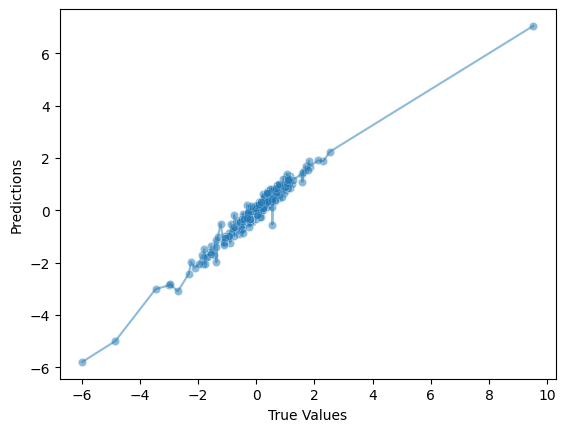

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=y_test, y=preds, alpha=0.5)
sns.lineplot(x=y_test, y=preds, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')

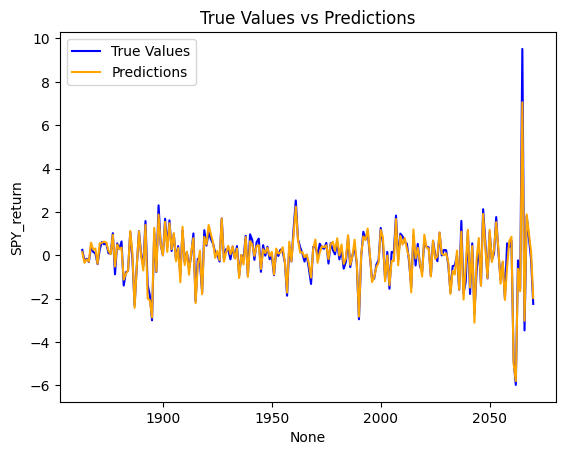

In [45]:
def line_plot(index,test,preds):
    sns.lineplot(x=index, y=test, label='True Values', color='blue')
    sns.lineplot(x=index, y=preds, label='Predictions', color='orange')
    plt.title('True Values vs Predictions')

line_plot(x_test.index, y_test, preds)

### Because I am using return data , if I want to check it and plot to see the quality of the prediction I need to convert to real prices:

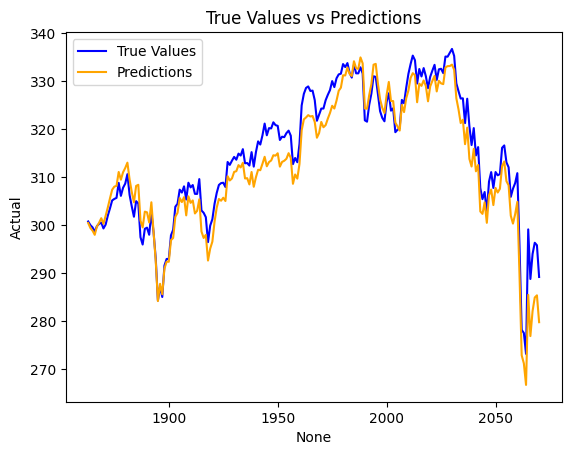

In [46]:
def convert_return_to_price(y_test, preds, initial_price=300):
    """
    Convert percentage returns to price series.
    
    Parameters:
    - returns: pd.Series of percentage returns
    - initial_price: float, initial price to start the series from
    
    Returns:
    - pd.Series of prices
    """
    price_actual = initial_price * (1 + y_test / 100).cumprod()
    price_predicted = initial_price * (1 + preds / 100).cumprod()
    df = pd.DataFrame({'Actual': price_actual, 'Predicted': price_predicted}, index=y_test.index)
    return df

check_df = convert_return_to_price(y_test, preds, initial_price=300)


line_plot(check_df.index, check_df['Actual'], check_df['Predicted'])



In [47]:
model_lst = pd.DataFrame()

In [48]:
model_dict = {'model': 'XGBRegressor with nasdaq',}
new_row = pd.DataFrame([{**model_dict , **regressionMetrics(y_test,preds)}])
model_lst = pd.concat([model_lst, new_row], ignore_index=True)
model_lst

,model,MSE,RMSE,MAE,R2,RMSLE
0,XGBRegressor with nasdaq,0.078714,0.280561,0.183838,0.952007,Not applicable (values ≤ -1)


# Feture selection
Using it on the XGBoost model 

In [49]:
model = xgb.XGBRegressor(n_estimators=200, random_state=42)
model.fit(x, y)

# Create DataFrame of importance
feature_importance = pd.DataFrame({
    'feature': x.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top N
selected_features = feature_importance[feature_importance['importance'] > 0.00]['feature'].tolist()

In [50]:
# looking at the support and resistance signal importance 
l = ['SUPPORT_Signal', 'RESISTANCE_Signal', 'yest_support_signal', 'yest_resistance_signal']
#feature_importance.head(20)
print(feature_importance[['feature','importance']].loc[feature_importance['feature'].isin(l)].sort_values(by='importance', ascending=False))

                    feature  importance
97           SUPPORT_Signal    0.000329
100  yest_resistance_signal    0.000283
99      yest_support_signal    0.000246
98        RESISTANCE_Signal    0.000046


In [51]:
df['Actual_FOMC'].head(20)

0    -500.00
1    -500.00
2    -500.00
3    -500.00
4    -500.00
5    -500.00
6    -500.00
7       0.75
8    -500.00
9    -500.00
10   -500.00
11   -500.00
12   -500.00
13   -500.00
14   -500.00
15   -500.00
16   -500.00
17   -500.00
18   -500.00
19   -500.00
Name: Actual_FOMC, dtype: float64

# ploting the importance 

Text(0.5, 0, 'Importance')

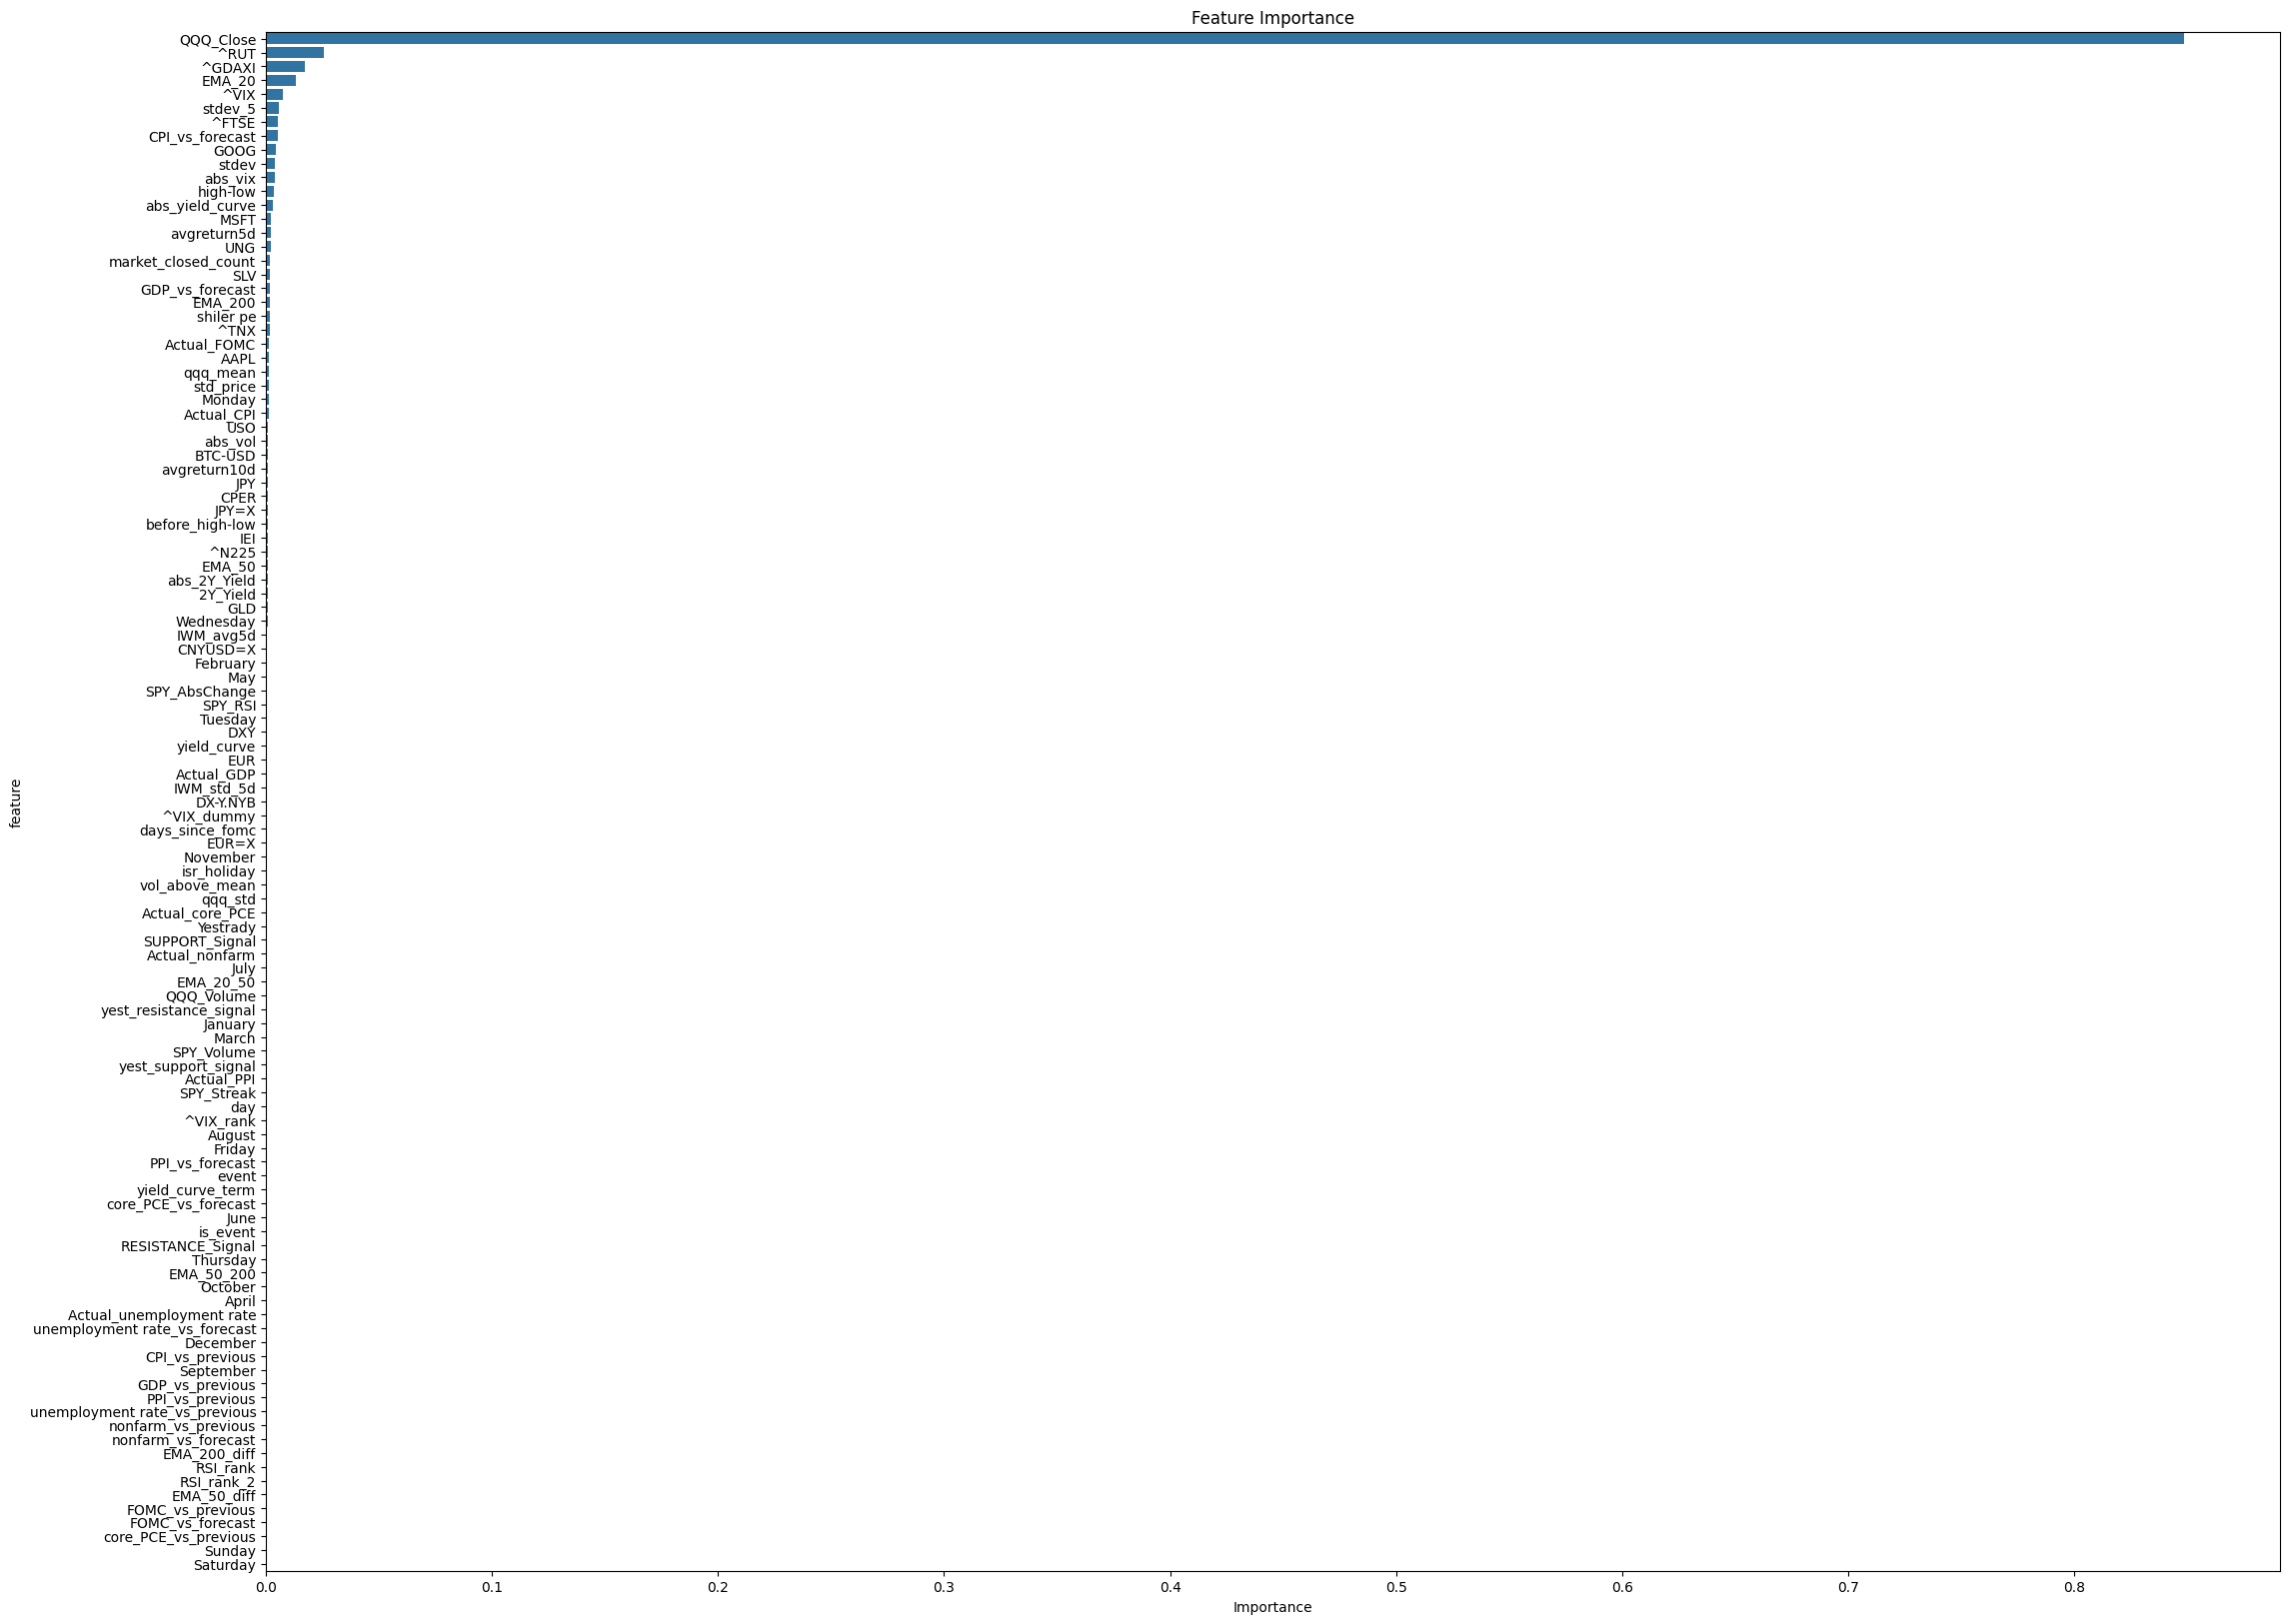

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(26, 20))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')

In [54]:
df['SPY_RSI'].head()

0    54.669773
1    61.857468
2    63.926955
3    63.965540
4    59.510150
Name: SPY_RSI, dtype: float64

In [261]:
df['SPY_Volume'].head()

0   -10.789544
1    20.971780
2     0.848583
3    -6.178462
4   -13.127196
Name: SPY_Volume, dtype: float64

In [373]:
print(len(selected_features))

81


### Using permutation_importance

In [55]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, x, y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]
important_features = x.columns[sorted_idx[:38]] # 38 is the number that yields the best resaults 
print(important_features)

Index(['QQQ_Close', '^RUT', '^VIX', 'EMA_20', 'avgreturn5d', '^GDAXI',
       'stdev_5', 'qqq_mean', 'GOOG', 'MSFT', '^FTSE', 'AAPL', 'std_price',
       'abs_yield_curve', 'high-low', 'UNG', 'stdev', 'abs_vix', 'SLV', '^TNX',
       'EMA_200', 'BTC-USD', 'EMA_50', 'USO', 'CPER', 'JPY=X', 'CNYUSD=X',
       'before_high-low', 'SPY_RSI', 'GLD', 'IWM_avg5d', 'shiler pe',
       'SPY_Volume', 'abs_vol', '^N225', 'SPY_AbsChange', 'avgreturn10d',
       'IEI'],
      dtype='object')


In [455]:
important_features = x.columns[sorted_idx[:45]] # 38 is the number that yields the best resaults 
print(important_features)

Index(['QQQ_Close', '^RUT', '^VIX', 'EMA_20', '^GDAXI', 'MSFT', 'stdev_5',
       '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve',
       'std_price', 'UNG', 'abs_vix', 'SLV', 'stdev', 'BTC-USD', 'EMA_50',
       'EMA_200', '^TNX', 'USO', 'IWM_avg5d', 'shiler pe', 'JPY=X', 'GLD',
       'SPY_AbsChange', 'SPY_Volume', '^N225', 'CPER', 'CNYUSD=X',
       'before_high-low', 'abs_vol', 'IWM_std_5d', 'yield_curve', 'IEI',
       'DX-Y.NYB', 'EUR=X', 'avgreturn10d', '2Y_Yield', 'EUR', 'SPY_RSI',
       'DXY', 'JPY'],
      dtype='object')


In [56]:
y_s = df['SPY_return']
x_s = df[important_features]
x_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QQQ_Close        2071 non-null   float64
 1   ^RUT             2071 non-null   float64
 2   ^VIX             2071 non-null   float64
 3   EMA_20           2071 non-null   float64
 4   avgreturn5d      2071 non-null   float64
 5   ^GDAXI           2071 non-null   float64
 6   stdev_5          2071 non-null   float64
 7   qqq_mean         2071 non-null   float64
 8   GOOG             2071 non-null   float64
 9   MSFT             2071 non-null   float64
 10  ^FTSE            2071 non-null   float64
 11  AAPL             2071 non-null   float64
 12  std_price        2071 non-null   float64
 13  abs_yield_curve  2071 non-null   float64
 14  high-low         2071 non-null   float64
 15  UNG              2071 non-null   float64
 16  stdev            2071 non-null   float64
 17  abs_vix       

**Save the best features**

In [466]:
lst1 = important_features.to_list()
lst1.append('ds')
lst1.append('SPY_return')
_df_ = df[lst1]
_df_.to_pickle('df_with_QQQ.pkl')

# Train again

In [60]:
split = int(len(y)*0.9)
x_train = x_s.iloc[:split]
x_test = x_s.iloc[split:]
y_train = y_s.iloc[:split]
y_test = y_s.iloc[split:]


In [58]:


divide = [0.85,0.9,0.95] # testing for diffrent test size data 
for train in divide:
    split = int(len(y)*train)
    x_train = x_s.iloc[:split]
    x_test = x_s.iloc[split:]
    y_train = y_s.iloc[:split]
    y_test = y_s.iloc[split:]

    # Parameters
    best_w = None
    best_mae = float('inf')

    num_samples = len(y_train)
    results = []

    # Test weight range from 1.0 to 3.0 in 0.1 steps
    for w in np.arange(1.0, 3.1, 0.1):
        # Create sample weights linearly increasing from 1 to w
        weights = np.linspace(1, w, num_samples)
        weights = weights / np.mean(weights)  # Normalize to mean=1

        # Fit XGBoost with weights
        model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
        model.fit(x_train, y_train, sample_weight=weights)

        # Predict and evaluate on test set
        predictions = model.predict(x_test)
        mae = mean_absolute_error(y_test, predictions)

        results.append((w, mae))
        #print(f"w={w:.1f}, MAE={mae:.4f}")

        # Track best
        if mae < best_mae:
            best_mae = mae
            best_w = w
            
    # Recreate sample weights using best_w = 3
    num_samples = len(y_train)
    weights = np.linspace(1, best_w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1
    # Fit the model
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"Train size={train:.2f}, MAE={mae:.4f} and wight={best_w:.2f}")
    print(regressionMetrics(y_test,predictions))


Train size=0.85, MAE=0.1715 and wight=2.60
{'MSE': 0.057962718237445594, 'RMSE': np.float64(0.2407544770870224), 'MAE': 0.1714753168141952, 'R2': 0.9539652481700269, 'RMSLE': 'Not applicable (values ≤ -1)'}
Train size=0.90, MAE=0.1800 and wight=1.50
{'MSE': 0.07578922868266444, 'RMSE': np.float64(0.27529843567057266), 'MAE': 0.18003450416771882, 'R2': 0.9537902502789823, 'RMSLE': 'Not applicable (values ≤ -1)'}
Train size=0.95, MAE=0.2015 and wight=1.30
{'MSE': 0.11390534183890075, 'RMSE': np.float64(0.3374986545734675), 'MAE': 0.20151677361392725, 'R2': 0.9536871937736324, 'RMSLE': 'Not applicable (values ≤ -1)'}


In [ ]:
model, preds = train_xgb_with_slope_weights(
    x_train, y_train, x_test, y_test,
    weight_max=best_w
)

In [64]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train)
weights = np.linspace(1, 1.3, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
xg_ind.fit(x_train, y_train,sample_weight=weights)
predicted_xg_ind2 = xg_ind.predict(x_test)
regressionMetrics(y_test,predicted_xg_ind2)

{'MSE': 0.07757587334436006,
 'RMSE': np.float64(0.2785244573540357),
 'MAE': 0.1886740922735048,
 'R2': 0.9527009081113369,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# permutation importance resaults:

 ## Added iwm avg & std using top 45 :
{'MSE': 0.15929380586598665,
 'RMSE': np.float64(0.39911628113368997),
 'MAE': 0.2546392991474355,
 'R2': 0.9102085438157346,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## Added cny/usd and shiler pe using top 45
{'MSE': 0.16463289362207897,
 'RMSE': np.float64(0.40574979189406735),
 'MAE': 0.25596635987221805,
 'R2': 0.9063334285715172,
 'RMSLE': 'Not applicable (values ≤ -1)'}

## PE & DXY with top 45 after convert iwm to future:
{'MSE': 0.12517320557926181,
 'RMSE': np.float64(0.3537982554779797),
 'MAE': 0.2525133128689182,
 'R2': 0.9236801508323276,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## PE no DXY with top 45 after convert iwm to future:
 {'MSE': 0.12269950869276472,
 'RMSE': np.float64(0.3502848964668113),
 'MAE': 0.25094706873793043,
 'R2': 0.9251883983233966,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## PE no DXY with top 48 after convert iwm to future:
{'MSE': 0.1218085861749724,
 'RMSE': np.float64(0.34901086827629363),
 'MAE': 0.2531826405943809,
 'R2': 0.9257316062077304,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## The one above + added the RSI with top 48:
 {'MSE': 0.11128356285769345,
 'RMSE': np.float64(0.33359191065985616),
 'MAE': 0.23806478166590173,
 'R2': 0.9321488597113353,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 # The one above + DXY using top 48:
 {'MSE': 0.11052535218260515,
 'RMSE': np.float64(0.3324535338699307),
 'MAE': 0.24198216163944508,
 'R2': 0.932611151334309,
 'RMSLE': 'Not applicable (values ≤ -1)'}

  # Added s/r aread and approximity & using top 55:
  {'MSE': 0.11071318073535778,
 'RMSE': np.float64(0.3327359023840947),
 'MAE': 0.24075361174013843,
 'R2': 0.932496629646148,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# With currencies and yields as abs values:
 'MSE': 0.10751856352955753,
 'RMSE': np.float64(0.3279002341102512),
 'MAE': 0.23699678654895437,
 'R2': 0.9344444323101992,

# Added Nasdaq data:
 'MSE': 0.07405913400012867,
 'RMSE': np.float64(0.27213807892341835),
 'MAE': 0.17667162334027636,
 'R2': 0.9548451131356606,


In [65]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train)
results = []

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight with added slope w={best_w:.2f} with MAE={best_mae:.4f}")


w=1.0, MAE=0.1853
w=1.1, MAE=0.1849
w=1.2, MAE=0.1890
w=1.3, MAE=0.1887
w=1.4, MAE=0.1859
w=1.5, MAE=0.1800
w=1.6, MAE=0.1934
w=1.7, MAE=0.1858
w=1.8, MAE=0.1880
w=1.9, MAE=0.1856
w=2.0, MAE=0.1862
w=2.1, MAE=0.1934
w=2.2, MAE=0.1828
w=2.3, MAE=0.1906
w=2.4, MAE=0.1834
w=2.5, MAE=0.1913
w=2.6, MAE=0.1915
w=2.7, MAE=0.1883
w=2.8, MAE=0.1863
w=2.9, MAE=0.1884
w=3.0, MAE=0.1848

✅ Best weight with added slope w=1.50 with MAE=0.1800


## Display the actual vs the best predicted using XGBoost

In [460]:
check_df = pd.concat([y_test, pd.Series(predicted_xg_ind2, index=y_test.index)], axis=1)
check_df.columns = ['Actual', 'Predicted']  # Optional: name the columns
check_df.tail(20)

,Actual,Predicted
2051,-0.218489,-0.292804
2052,0.082465,0.200295
2053,1.764600,1.558881
2054,0.157433,0.254215
2055,-1.115693,-1.287325
2056,-0.330698,-0.353618
2057,-1.973722,-2.074402
2058,0.553852,-0.524296
2059,0.378124,0.679793
2060,0.672819,0.945463


In [2360]:
df['EMA_200_diff'].tail(20)

2051    -0.703613
2052    -0.614461
2053     1.118950
2054     1.261697
2055     0.146181
2056    -0.183287
2057    -2.178544
2058    -1.599666
2059    -1.204832
2060    -0.523199
2061    -5.579421
2062   -12.166347
2063   -12.304805
2064   -13.955914
2065    -4.014360
2066    -7.666042
2067    -5.695512
2068    -4.814028
2069    -4.945731
2070    -7.278152
Name: EMA_200_diff, dtype: float64

In [461]:
check_df.head(20)
check_df['gp_present']= np.abs(check_df['Actual'] - check_df['Predicted'])
check_df['mean_10'] = check_df['gp_present'].mean()
check_df['above_mean'] = (check_df['gp_present'] > check_df['mean_10']).astype(int)
check_df['diffrent_sign'] = (check_df['Actual'] * check_df['Predicted'] < 0).astype(int)
check_df['above_mean'].tail(20)

2051    0
2052    0
2053    1
2054    0
2055    0
2056    0
2057    0
2058    1
2059    1
2060    1
2061    0
2062    1
2063    1
2064    0
2065    1
2066    1
2067    1
2068    1
2069    0
2070    1
Name: above_mean, dtype: int64

In [462]:
check_df[['Actual','Predicted','above_mean','diffrent_sign']].head(25)

,Actual,Predicted,above_mean,diffrent_sign
1863,0.252133,0.172662,0,0
1864,-0.252593,-0.361397,0,0
1865,-0.156213,-0.164916,0,0
1866,-0.306517,-0.253522,0,0
1867,0.393359,0.651112,1,0
1868,0.157243,0.264152,0,0
1869,0.090732,0.273981,0,0
1870,-0.408365,-0.335497,0,0
1871,0.267556,0.474691,1,0
1872,0.619532,0.606239,0,0


In [640]:
print(len(y_test))

208


In [463]:
check_df['price_actual'] = 300 * (1 + check_df['Actual'] / 100).cumprod()
check_df['price_predicted'] = 300 * (1 + check_df['Predicted'] / 100).cumprod()

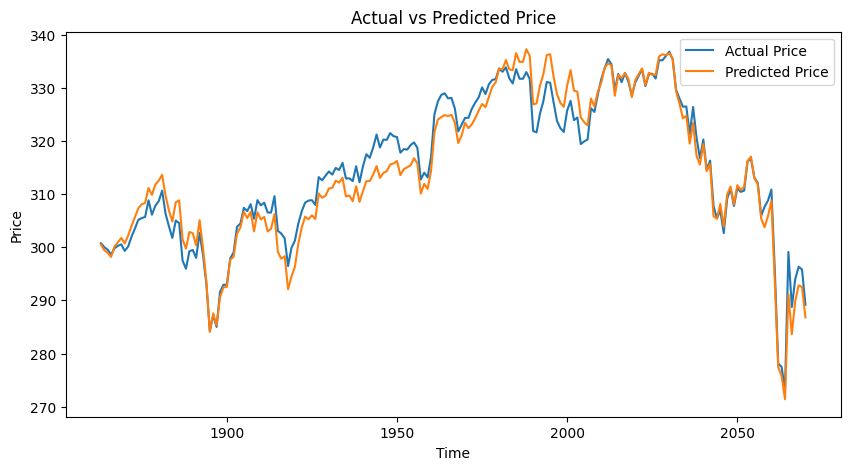

In [464]:
plt.figure(figsize=(10, 5))
plt.plot(check_df['price_actual'], label='Actual Price')
plt.plot(check_df['price_predicted'], label='Predicted Price')
plt.legend()
plt.title('Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Grid search

In [2361]:
xgb_param_grid = {
    'n_estimators': [200,300],
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.6,0.8],
    'gamma':[0, 0.1],
    'reg_alpha':[0, 0.1],
    'colsample_bytree': [0.6, 0.8]
}

In [2362]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
# Create custom scorer to minimize MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define candidate weight scalings to search over
w_candidates = np.arange(1.0, 3.1, 0.2)  # Try from 1.0 to 3.0 in steps of 0.2

best_mae = float('inf')
best_xgb_model = None
best_w = None
best_params = None

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for w in w_candidates:
    print(f"\n🔍 Testing weight slope: {w:.2f}")
    
    # Create weights linearly increasing from 1 to w
    num_samples = len(y_train)
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Grid search
    xgb_grid = GridSearchCV(
        xgb.XGBRegressor(n_jobs=-1, random_state=42, verbosity=0),
        param_grid=xgb_param_grid,
        cv=tscv,
        scoring=mae_scorer,
        verbose=0
    )

    xgb_grid.fit(x_train, y_train, sample_weight=weights)
    model = xgb_grid.best_estimator_

    # Evaluate on test set
    preds = model.predict(x_test)
    mae = mean_absolute_error(y_test, preds)
    print(f"→ MAE: {mae:.4f} | Best Params: {xgb_grid.best_params_}")

    if mae < best_mae:
        best_mae = mae
        best_xgb_model = model
        best_w = w
        best_params = xgb_grid.best_params_

# 🎉 Final result
print(f"\n✅ Best XGBoost Model")
print(f"MAE: {best_mae:.4f}")
print(f"Weight slope (w): {best_w}")
print(f"Hyperparameters: {best_params}")



🔍 Testing weight slope: 1.00
→ MAE: 0.2719 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.20
→ MAE: 0.2824 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.40
→ MAE: 0.2726 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.60
→ MAE: 0.2777 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'subsample': 0.6}

🔍 Testing weight slope: 1.80
→ MAE: 0.2914 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 2.00
→ MAE

0    28.06
1    28.06
2    28.06
3    28.06
4    28.06
Name: shiler pe, dtype: float64

In [1]:
df['RSI'].head(20)

NameError: name 'df' is not defined

# Failed attempt to break

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

# assume df has a DateTimeIndex and a 'Close' column
# 1) detect local extrema
N = 10                   # how many points on each side to define a local max/min
df['local_max'] = np.nan
df['local_min'] = np.nan

# get the integer positions of the extrema
max_pos = argrelextrema(df['Close'].values, np.greater, order=N)[0]
min_pos = argrelextrema(df['Close'].values, np.less,    order=N)[0]

# mark them in the df
df.loc[df.index[max_pos], 'local_max'] = df['Close'].iloc[max_pos]
df.loc[df.index[min_pos], 'local_min'] = df['Close'].iloc[min_pos]

# 2) prepare our two feature columns
df['fails_to_break_up']   = 0
df['fails_to_break_down'] = 0

margin = 2.0   # $2 margin, for example

current_max = None
current_min = None
count_max   = 0
count_min   = 0

for idx in df.index:
    price = df.at[idx, 'Close']

    # if we hit a new local max → reset the upward‐break counter
    if not np.isnan(df.at[idx, 'local_max']):
        current_max = df.at[idx, 'local_max']
        count_max   = 0

    # if we hit a new local min → reset the downward‐break counter
    if not np.isnan(df.at[idx, 'local_min']):
        current_min = df.at[idx, 'local_min']
        count_min   = 0

    # —— handle the “up” failures —— 
    if current_max is not None:
        # in the approach zone but NOT broken above threshold+margin
        if (current_max - margin) <= price <= (current_max + margin) and price <= current_max + margin:
            # first time → 1, subsequent times → count+1
            count_max = count_max + 1 if count_max > 0 else 1
        # if price actually breaks out above
        elif price > current_max + margin:
            count_max   = 0
            current_max = None

    df.at[idx, 'fails_to_break_up'] = count_max

    # —— handle the “down” failures —— 
    if current_min is not None:
        # in the approach zone but NOT broken below threshold−margin
        if (current_min - margin) <= price <= (current_min + margin) and price >= current_min - margin:
            count_min = count_min + 1 if count_min > 0 else 1
        # if price actually breaks out below
        elif price < current_min - margin:
            count_min   = 0
            current_min = None

    df.at[idx, 'fails_to_break_down'] = count_min

# Inspect the last few rows
print(df[['Close','local_max','fails_to_break_up','local_min','fails_to_break_down']].tail(15))
